<a href="https://colab.research.google.com/github/mohandabdelhalim99/Deep_learning_practice/blob/main/State_farmDistraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
#State Farm Distracted Driver Detection
import random
from shutil import copyfile,copy
import shutil
import os
import cv2
from keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow
import keras  
from tensorflow.keras import layers,models,optimizers,losses
import tensorflow
import matplotlib.pyplot as plt
from keras.applications.imagenet_utils import preprocess_input

In [19]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Read_Data

In [2]:
from getpass import getpass
import os

user='mohandabdelhalim'
key='8f3e50196ed9b0965832ef84049433ee'


if '.kaggle' not in os.listdir('/root'):
       !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json


!kaggle competitions download -c state-farm-distracted-driver-detection
!chmod 777 *

100% 3.99G/4.00G [00:22<00:00, 130MB/s]
100% 4.00G/4.00G [00:22<00:00, 194MB/s]


In [3]:
!unzip /content/state-farm-distracted-driver-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: imgs/train/c7/img_56636.jpg  
  inflating: imgs/train/c7/img_56661.jpg  
  inflating: imgs/train/c7/img_56699.jpg  
  inflating: imgs/train/c7/img_56717.jpg  
  inflating: imgs/train/c7/img_56724.jpg  
  inflating: imgs/train/c7/img_56768.jpg  
  inflating: imgs/train/c7/img_56779.jpg  
  inflating: imgs/train/c7/img_56849.jpg  
  inflating: imgs/train/c7/img_56899.jpg  
  inflating: imgs/train/c7/img_56938.jpg  
  inflating: imgs/train/c7/img_5706.jpg  
  inflating: imgs/train/c7/img_57076.jpg  
  inflating: imgs/train/c7/img_57122.jpg  
  inflating: imgs/train/c7/img_57137.jpg  
  inflating: imgs/train/c7/img_5715.jpg  
  inflating: imgs/train/c7/img_57278.jpg  
  inflating: imgs/train/c7/img_57321.jpg  
  inflating: imgs/train/c7/img_57345.jpg  
  inflating: imgs/train/c7/img_57355.jpg  
  inflating: imgs/train/c7/img_5741.jpg  
  inflating: imgs/train/c7/img_57433.jpg  
  inflating: imgs/train/c7/img_5753.jpg  
  infla

## **Create Directories for imgDataGenerator**

In [4]:
try:
    os.mkdir('/content/state_farm_detection')
    os.mkdir('/content/state_farm_detection/training')
    os.mkdir('/content/state_farm_detection/validation')
    os.mkdir('/content/state_farm_detection/training/c0')
    os.mkdir('/content/state_farm_detection/training/c1')
    os.mkdir('/content/state_farm_detection/training/c2')
    os.mkdir('/content/state_farm_detection/training/c3')
    os.mkdir('/content/state_farm_detection/training/c4')
    os.mkdir('/content/state_farm_detection/training/c5')
    os.mkdir('/content/state_farm_detection/training/c6')
    os.mkdir('/content/state_farm_detection/training/c7')
    os.mkdir('/content/state_farm_detection/training/c8')
    os.mkdir('/content/state_farm_detection/training/c9')
    os.mkdir('/content/state_farm_detection/validation/c0')
    os.mkdir('/content/state_farm_detection/validation/c1')
    os.mkdir('/content/state_farm_detection/validation/c2')
    os.mkdir('/content/state_farm_detection/validation/c3')
    os.mkdir('/content/state_farm_detection/validation/c4')
    os.mkdir('/content/state_farm_detection/validation/c5')
    os.mkdir('/content/state_farm_detection/validation/c6')
    os.mkdir('/content/state_farm_detection/validation/c7')
    os.mkdir('/content/state_farm_detection/validation/c8')
    os.mkdir('/content/state_farm_detection/validation/c9')
except OSError:
    pass

In [5]:
SOURCE='/content/imgs/train'
TRAINNING_DIR='/content/state_farm_detection/training'
VALIDATION_DIR='/content/state_farm_detection/validation'

In [22]:
#shutil.rmtree('/content/state_farm_detection')  ##to remove directory with files in

In [17]:
#shutil.rmtree('/content/imgs') 

In [6]:
def split_data(SOURCE, TRAINING, VALIDATION, SPLIT_SIZE):
    for filename in os.listdir(SOURCE):
        file = SOURCE +'/'+ filename
        if os.path.getsize(file) > 0:
            print('ok')
        else:
            print(filename + " is zero length, so ignoring.")


    for clas in os.listdir(SOURCE):
        
        clas_dir= SOURCE +'/'+ clas
        len_clas=len(os.listdir(clas_dir))
        clas_shuffled=random.sample(os.listdir(clas_dir),len_clas)
        clas_train=clas_shuffled[0:int(len_clas*SPLIT_SIZE)]
        clas_val=clas_shuffled[int(len_clas*SPLIT_SIZE):]
        TRAINING_CLASS=TRAINING+'/'+clas
        VALIDATION_CLASS=VALIDATION+'/'+clas
        [shutil.move(SOURCE+'/'+clas+'/'+i ,TRAINING_CLASS) for i in clas_train]
        [shutil.move(SOURCE+'/'+clas+'/'+j ,VALIDATION_CLASS) for j in clas_val]
        

   




In [7]:
split_data(SOURCE, TRAINNING_DIR,VALIDATION_DIR,0.9)

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok


In [8]:
for clas in os.listdir(TRAINNING_DIR) :
  print (len(os.listdir(TRAINNING_DIR+'/'+clas)))

1801
2092
2111
2240
2080
2085
1719
2093
1916
2040


In [9]:
for clas in os.listdir(VALIDATION_DIR) :
  print (len(os.listdir(VALIDATION_DIR+'/'+clas)))

201
233
235
249
232
232
192
233
213
227


# Data_Preprocessing

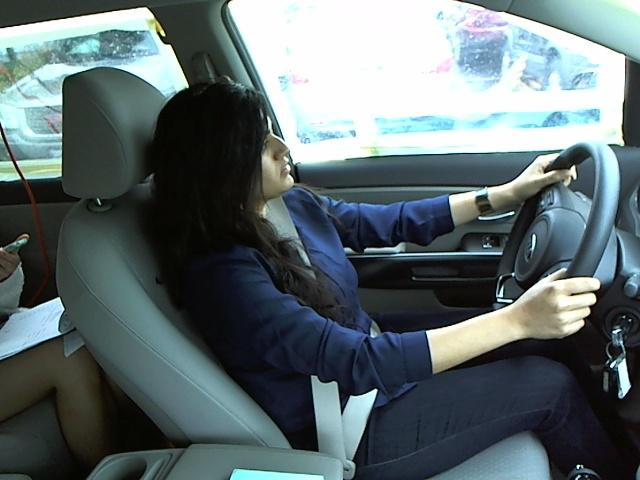

In [16]:
img_path='/content/state_farm_detection/training/c0/img_100050.jpg'
random_image=cv2.imread(img_path)
cv2_imshow(random_image)

In [17]:
print("the shape of an image is {}".format(random_image.shape))

the shape of an image is (480, 640, 3)


In [20]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen=ImageDataGenerator(rescale=1./255)

In [29]:
train_generator = train_datagen.flow_from_directory(
        TRAINNING_DIR,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 20177 images belonging to 10 classes.


In [23]:
next(train_generator)[1]

array([6., 0., 4., 3., 6., 0., 3., 1., 8., 6., 5., 4., 1., 4., 8., 1., 4.,
       7., 6., 3.], dtype=float32)

In [30]:
validation_generator = val_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 2247 images belonging to 10 classes.


# MODEL

**BASE-LINE DENSE**

In [60]:
model_dense=models.Sequential()
model_dense.add(layers.Flatten())
model_dense.add(layers.Dense(128,activation='relu'))
model_dense.add(layers.Dense(64,activation='relu'))
model_dense.add(layers.Dense(64,activation='relu'))
model_dense.add(layers.Dense(32,activation='relu'))
model_dense.add(layers.Dense(32,activation='relu'))  
model_dense.add(layers.Dense(10,activation='softmax'))                         
                             

In [61]:
model_dense.build(input_shape=(None,150*150*3))
model_dense.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 67500)             0         
                                                                 
 dense_30 (Dense)            (None, 128)               8640128   
                                                                 
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 dense_32 (Dense)            (None, 64)                4160      
                                                                 
 dense_33 (Dense)            (None, 32)                2080      
                                                                 
 dense_34 (Dense)            (None, 32)                1056      
                                                                 
 dense_35 (Dense)            (None, 10)               

In [64]:

model_dense.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [65]:
history = model_dense.fit_generator(
      train_generator,
      epochs=30,
      validation_data=validation_generator
      )

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


1009/1009 [==============================] - 104s 100ms/step - loss: 2.0974 - acc: 0.2518 - val_loss: 1.8137 - val_acc: 0.4299
Epoch 2/30
1009/1009 [==============================] - 100s 99ms/step - loss: 1.5303 - acc: 0.5470 - val_loss: 1.3577 - val_acc: 0.6302
Epoch 3/30
1009/1009 [==============================] - 99s 98ms/step - loss: 1.0719 - acc: 0.7541 - val_loss: 0.9228 - val_acc: 0.7997
Epoch 4/30
1009/1009 [==============================] - 100s 99ms/step - loss: 0.7582 - acc: 0.8438 - val_loss: 0.6734 - val_acc: 0.8772
Epoch 5/30
1009/1009 [==============================] - 99s 98ms/step - loss: 0.5467 - acc: 0.8967 - val_loss: 0.5001 - val_acc: 0.9034
Epoch 6/30
1009/1009 [==============================] - 99s 98ms/step - loss: 0.4027 - acc: 0.9264 - val_loss: 0.3567 - val_acc: 0.9426
Epoch 7/30
1009/1009 [==============================] - 101s 100ms/step - loss: 0.3016 - acc: 0.9488 - val_loss: 0.3037 - val_acc: 0.9399
Epoch 8/30
1009/1009 [==============================]

KeyboardInterrupt: ignored

 **Base-Line CNN**

In [68]:
class myCallback(tensorflow.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True


In [69]:
model_cnn=models.Sequential()

model_cnn.add(layers.Conv2D(128,(3,3),activation='relu',input_shape=(150,150,3)))
model_cnn.add(layers.MaxPooling2D(2,2))
model_cnn.add(layers.Conv2D(64,(3,3),activation='relu'))
model_cnn.add(layers.MaxPooling2D(2,2))
model_cnn.add(layers.Conv2D(32,(3,3),activation='relu'))
model_cnn.add(layers.MaxPooling2D(2,2))
model_cnn.add(layers.Conv2D(16,(3,3),activation='relu'))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(128,activation='relu'))
model_cnn.add(layers.Dense(10,activation='softmax'))

In [70]:
model_cnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 32)      

In [72]:
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [73]:
callbacks=myCallback()

In [74]:
history = model_cnn.fit_generator(
      train_generator,
      epochs=15,
      validation_data=validation_generator,
      callbacks=callbacks
      )

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


1009/1009 [==============================] - 125s 114ms/step - loss: 1.9901 - acc: 0.3142 - val_loss: 1.5048 - val_acc: 0.5096
Epoch 2/15
1009/1009 [==============================] - 113s 112ms/step - loss: 1.1345 - acc: 0.6311 - val_loss: 0.9851 - val_acc: 0.6604
Epoch 3/15
1009/1009 [==============================] - 113s 112ms/step - loss: 0.6407 - acc: 0.8029 - val_loss: 0.5103 - val_acc: 0.8420
Epoch 4/15
1009/1009 [==============================] - 112s 111ms/step - loss: 0.3968 - acc: 0.8856 - val_loss: 0.3359 - val_acc: 0.9128
Epoch 5/15
1009/1009 [==============================] - 114s 112ms/step - loss: 0.2703 - acc: 0.9269 - val_loss: 0.2651 - val_acc: 0.9315
Epoch 6/15
1009/1009 [==============================] - 112s 111ms/step - loss: 0.1997 - acc: 0.9440 - val_loss: 0.2583 - val_acc: 0.9297
Epoch 7/15
1009/1009 [==============================] - 113s 112ms/step - loss: 0.1525 - acc: 0.9587 - val_loss: 0.1888 - val_acc: 0.9528
Epoch 8/15
1009/1009 [=======================

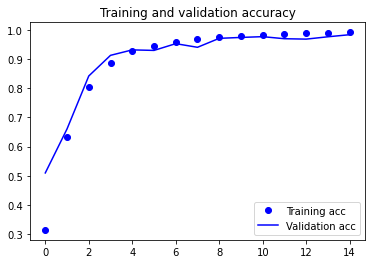

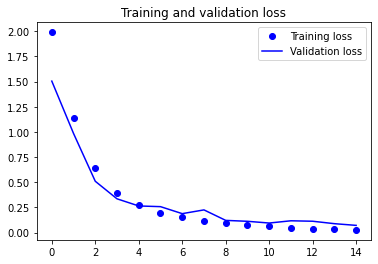

In [75]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Data_Augmention+TransferLearning**

In [82]:
train_datagen_aug= ImageDataGenerator(
    preprocessing_function=preprocess_input,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


val_datagen_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

In [89]:
from tensorflow.keras.applications.vgg16 import VGG16
model_vgg2=VGG16()

In [97]:
model_vgg16_v2=VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3))

In [98]:
model_vgg = models.Sequential()
model_vgg.add(model_vgg16_v2)
model_vgg.add(layers.Flatten())
model_vgg.add(layers.Dense(128, activation='relu'))
model_vgg.add(layers.Dense(128, activation='relu'))
model_vgg.add(layers.Dense(10, activation='softmax'))

In [99]:
model_vgg16_v2.trainable=False

In [100]:
train_generator_aug = train_datagen_aug.flow_from_directory(
        TRAINNING_DIR,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 20177 images belonging to 10 classes.


In [101]:
validation_generator_aug = val_datagen_aug.flow_from_directory(
        VALIDATION_DIR,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 2247 images belonging to 10 classes.


In [102]:
model_vgg.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [103]:
history = model_vgg.fit_generator(
      train_generator_aug,
      epochs=15,
      validation_data=validation_generator_aug
     
      )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/15
1009/1009 [==============================] - 216s 213ms/step - loss: 4.6198 - acc: 0.1435 - val_loss: 2.5349 - val_acc: 0.1980
Epoch 2/15
1009/1009 [==============================] - 213s 211ms/step - loss: 2.3577 - acc: 0.1693 - val_loss: 2.1852 - val_acc: 0.2261
Epoch 3/15
1009/1009 [==============================] - 213s 211ms/step - loss: 2.2074 - acc: 0.2068 - val_loss: 2.0183 - val_acc: 0.2848
Epoch 4/15
1009/1009 [==============================] - 216s 214ms/step - loss: 2.0905 - acc: 0.2527 - val_loss: 1.8271 - val_acc: 0.3578
Epoch 5/15
1009/1009 [==============================] - 213s 211ms/step - loss: 1.9736 - acc: 0.3020 - val_loss: 1.6675 - val_acc: 0.4148
Epoch 6/15
1009/1009 [==============================] - 214s 212ms/step - loss: 1.8585 - acc: 0.3437 - val_loss: 1.4938 - val_acc: 0.4824
Epoch 7/15
1009/1009 [==============================] - 211s 209ms/step - loss: 1.7620 - acc: 0.3789 - val_loss: 1.3577 - val_acc: 0.5229
Epoch 8/15
1009/1009 [============